In [1]:

#importing required libraries
import pandas as pd
import numpy as np
import os
from glob import glob
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

In [2]:
warnings.filterwarnings('ignore')


In [3]:
# Read metadata
skinDf = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# Set image size
img_size = (128, 128)

In [4]:
labelEncoder = LabelEncoder()
skinDf['label'] = labelEncoder.fit_transform(skinDf['dx'])

# Resample to balance classes
dfs_by_label_resampled = {}
n_samples = 800
for label in range(7):
    df_label_resampled = resample(skinDf[skinDf['label'] == label], n_samples=n_samples, replace=True, random_state=42)
    dfs_by_label_resampled[label] = df_label_resampled
balanced_df = pd.concat(dfs_by_label_resampled.values()).sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
# Load images
imgPath = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/', '*', '*.jpg'))}
balanced_df['image'] = balanced_df['image_id'].map(imgPath.get).map(lambda x: np.asarray(Image.open(x).resize(img_size)) / 255)

# Split data
x = np.asarray(balanced_df['image'].to_list())
y = to_categorical(balanced_df['label'], num_classes=7)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42, shuffle=True)

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(128, 128, 3)))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

In [7]:
# Compile model with a lower learning rate
model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train model
history = model.fit(x_train, y_train, epochs=200, batch_size=8, validation_data=(x_test, y_test), 
callbacks=[EarlyStopping(patience=5), reduce_lr])

Epoch 1/200


I0000 00:00:1732517395.933524      94 service.cc:145] XLA service 0x78c7a8018210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732517395.933597      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 21/560 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1736 - loss: 2.3706 

I0000 00:00:1732517403.958704      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


560/560 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.2159 - loss: 2.1754 - val_accuracy: 0.4009 - val_loss: 1.5694 - learning_rate: 1.0000e-04
Epoch 2/200
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3204 - loss: 1.8413 - val_accuracy: 0.4643 - val_loss: 1.4171 - learning_rate: 1.0000e-04
Epoch 3/200
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3598 - loss: 1.6975 - val_accuracy: 0.4991 - val_loss: 1.3351 - learning_rate: 1.0000e-04
Epoch 4/200
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3798 - loss: 1.6099 - val_accuracy: 0.5420 - val_loss: 1.2613 - learning_rate: 1.0000e-04
Epoch 5/200
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3921 - loss: 1.5949 - val_accuracy: 0.5402 - val_loss: 1.2457 - learning_rate: 1.0000e-04
Epoch 6/200
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4187 - loss: 1.5002 - val_accuracy: 0.5491 - val_loss: 1.2146 - learning_rate: 1.0000e-04
Epoch 7/200
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4

In [9]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8909 - loss: 0.3370
Test Accuracy: 0.8776785731315613
Test Loss: 0.37286826968193054


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


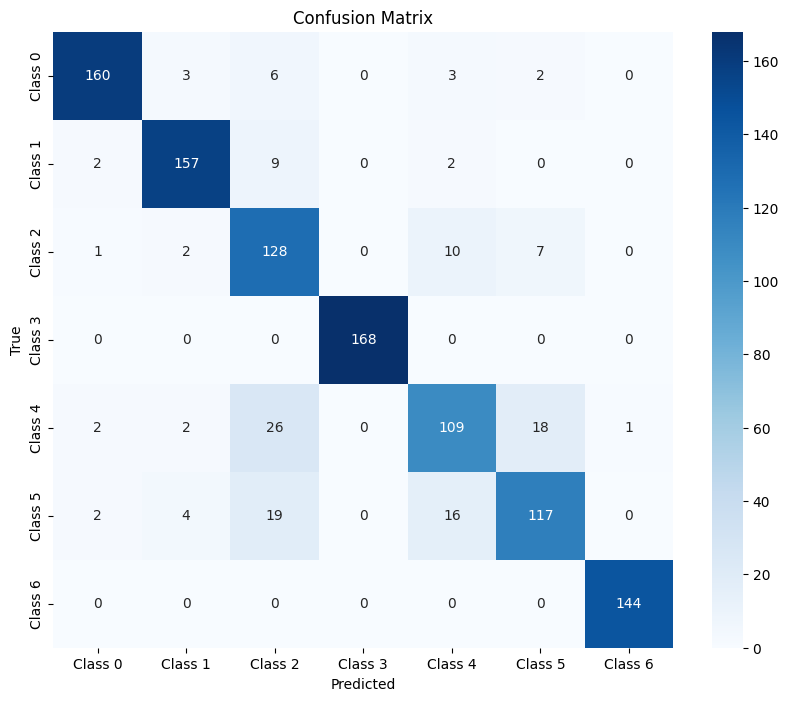

In [10]:
import numpy as np
y_pred = model.predict(x_test)
import seaborn as sns

# Convert one-hot encoded labels to integer labels
y_true_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_int, y_pred_int)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
model.save("skin_cancer_model.h5")